<a href="https://colab.research.google.com/github/dendhipratama/PENGOLAHAN-CITRA/blob/main/TUGAS_PENGOLAHANCITRA6_DENDHI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Latihan 1 : Smoothing spasial vs Frekuensi (Citra Lenna)***

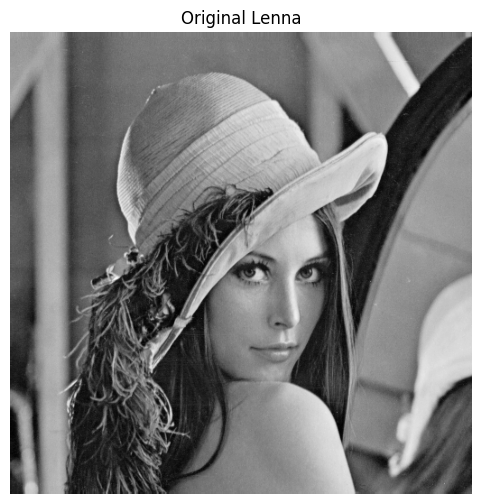

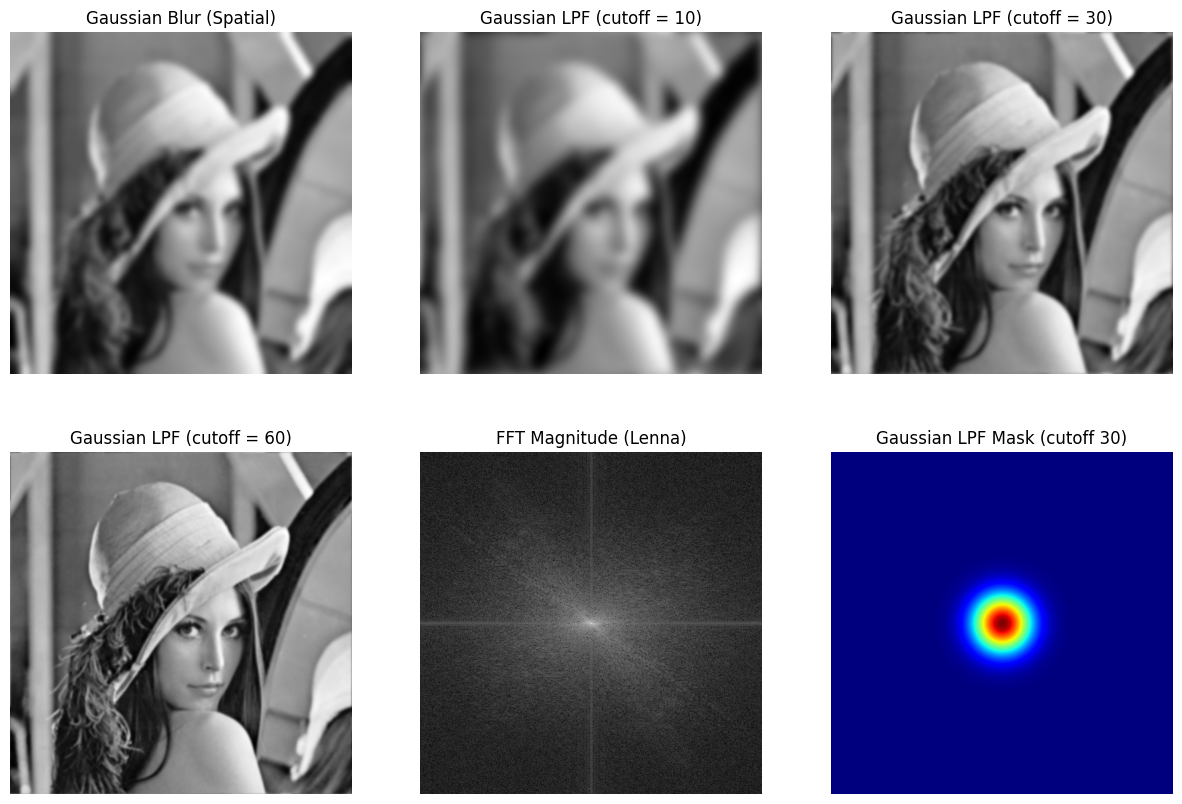

,Filter,MSE,PSNR,SSIM
0,Spatial Gaussian σ=5,0.004164,23.804590,0.663790
1,LPF cutoff=10,0.011230,19.496043,0.561445
2,LPF cutoff=30,0.005667,22.466271,0.745136
3,LPF cutoff=60,0.003439,24.635214,0.866232


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from skimage.metrics import structural_similarity as ssim
from math import log10

# Download Lenna
url = "https://github.com/lenna-project/ultraface-plugin/raw/main/assets/lenna.png"
img_data = requests.get(url).content

with open("lenna.png", "wb") as f:
    f.write(img_data)

# Load + convert to grayscale
img = cv2.imread("lenna.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

plt.figure(figsize=(6,6))
plt.imshow(img_gray, cmap='gray')
plt.title("Original Lenna")
plt.axis('off')

sigma_spatial = 5
spatial_blur = cv2.GaussianBlur(img_gray, (0,0), sigmaX=sigma_spatial)

def gaussian_lpf_freq(img, cutoff):
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2

    # FFT
    F = np.fft.fft2(img)
    F_shift = np.fft.fftshift(F)

    # Frequency coordinates
    u = np.arange(-crow, rows - crow)
    v = np.arange(-ccol, cols - ccol)
    U, V = np.meshgrid(u, v)

    D = np.sqrt(U**2 + V**2)

    # Gaussian LPF
    H = np.exp(-(D**2) / (2 * (cutoff**2)))

    filtered = F_shift * H
    F_ishift = np.fft.ifftshift(filtered)
    out = np.real(np.fft.ifft2(F_ishift))

    out = (out - out.min()) / (out.max() - out.min())
    return out, H, F_shift

lpf10, H10, F10 = gaussian_lpf_freq(img_gray, 10)
lpf30, H30, F30 = gaussian_lpf_freq(img_gray, 30)
lpf60, H60, F60 = gaussian_lpf_freq(img_gray, 60)

fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0,0].imshow(spatial_blur, cmap='gray')
ax[0,0].set_title("Gaussian Blur (Spatial)")
ax[0,0].axis('off')

ax[0,1].imshow(lpf10, cmap='gray')
ax[0,1].set_title("Gaussian LPF (cutoff = 10)")
ax[0,1].axis('off')

ax[0,2].imshow(lpf30, cmap='gray')
ax[0,2].set_title("Gaussian LPF (cutoff = 30)")
ax[0,2].axis('off')

ax[1,0].imshow(lpf60, cmap='gray')
ax[1,0].set_title("Gaussian LPF (cutoff = 60)")
ax[1,0].axis('off')

# Magnitude spectrum
ax[1,1].imshow(np.log(1 + np.abs(F30)), cmap='gray')
ax[1,1].set_title("FFT Magnitude (Lenna)")
ax[1,1].axis('off')

ax[1,2].imshow(H30, cmap='jet')
ax[1,2].set_title("Gaussian LPF Mask (cutoff 30)")
ax[1,2].axis('off')

plt.show()

def MSE(a, b):
    return np.mean((a - b) ** 2)

def PSNR(a, b):
    mse = MSE(a, b)
    return 10 * log10(1.0 / mse)

def SSIM(a, b):
    return ssim(a, b, data_range=1.0)

filters = {
    "Spatial Gaussian σ=5": spatial_blur,
    "LPF cutoff=10": lpf10,
    "LPF cutoff=30": lpf30,
    "LPF cutoff=60": lpf60
}

import pandas as pd

rows = []
for name, img_f in filters.items():
    rows.append([
        name,
        MSE(img_gray, img_f),
        PSNR(img_gray, img_f),
        SSIM(img_gray, img_f)
    ])

df = pd.DataFrame(rows, columns=["Filter", "MSE", "PSNR", "SSIM"])
df

## ***Latihan 2 : Sharpening Laplacian vs HPF (Citra Moon)***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

,Metode,PSNR,SSIM
0,Laplacian Sharpening,23.725676,0.757750
1,Gaussian High-Pass,9.609341,0.432285


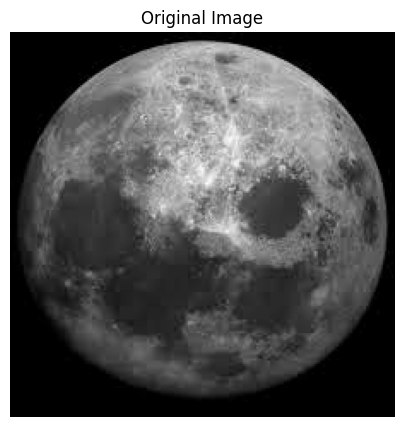

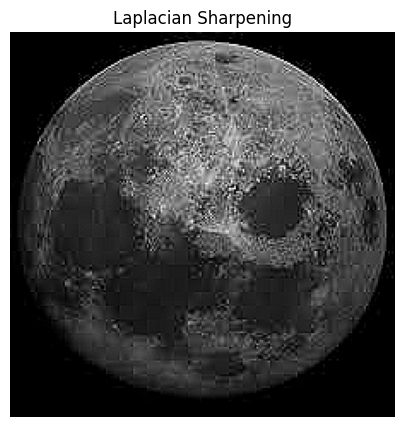

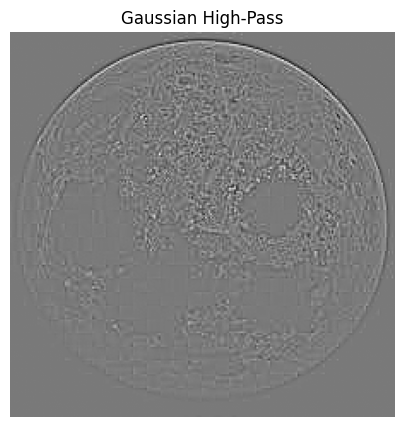

In [ ]:
# ===============================================================
# 1. Import Library
# ===============================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from math import log10
import pandas as pd

# ===============================================================
# 2. Load Image
# ===============================================================
# Pastikan kamu upload file "bulan bulet.jpg" ke Colab (panel kiri → Files → Upload)
img = cv2.imread('bulan bulet.jpg', cv2.IMREAD_GRAYSCALE)

if img is None:
    raise ValueError("Gambar tidak ditemukan! Pastikan nama file 'bulan bulet.jpg' sudah benar.")

img = img.astype(np.float32) / 255.0

plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.savefig("original_image.png", dpi=300)

# ===============================================================
# 3. Laplacian Sharpening
# ===============================================================

laplacian_kernel = np.array([[0, -1, 0],
                             [-1, 4, -1],
                             [0, -1, 0]], dtype=np.float32)

laplacian = cv2.filter2D(img, -1, laplacian_kernel)
laplacian_sharp = img + laplacian
laplacian_sharp = np.clip(laplacian_sharp, 0, 1)

plt.figure(figsize=(5,5))
plt.imshow(laplacian_sharp, cmap='gray')
plt.title("Laplacian Sharpening")
plt.axis('off')
plt.savefig("laplacian_sharpen.png", dpi=300)

# ===============================================================
# 4. Gaussian High Pass Filter
# ===============================================================

def high_pass_gaussian(img, cutoff=40):
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2

    # FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    # Gaussian HP Filter
    x = np.linspace(-crow, crow, rows)
    y = np.linspace(-ccol, ccol, cols)
    X, Y = np.meshgrid(y, x)
    D = np.sqrt(X**2 + Y**2)

    H = 1 - np.exp(-(D**2) / (2 * cutoff**2))

    filtered = fshift * H
    f_ishift = np.fft.ifftshift(filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.real(img_back)

    img_back = (img_back - img_back.min()) / (img_back.max() - img_back.min())
    return img_back

hp_gaussian = high_pass_gaussian(img, cutoff=40)

plt.figure(figsize=(5,5))
plt.imshow(hp_gaussian, cmap='gray')
plt.title("Gaussian High-Pass")
plt.axis('off')
plt.savefig("gaussian_highpass.png", dpi=300)

# ===============================================================
# 5. Hitung PSNR & SSIM
# ===============================================================

def PSNR(original, compared):
    mse = np.mean((original - compared) ** 2)
    if mse == 0:
        return 100
    return 10 * log10(1.0 / mse)

psnr_lap = PSNR(img, laplacian_sharp)
psnr_hp  = PSNR(img, hp_gaussian)

ssim_lap = ssim(img, laplacian_sharp, data_range=1.0)
ssim_hp  = ssim(img, hp_gaussian, data_range=1.0)

data = {
    "Metode": ["Laplacian Sharpening", "Gaussian High-Pass"],
    "PSNR": [psnr_lap, psnr_hp],
    "SSIM": [ssim_lap, ssim_hp]
}

df = pd.DataFrame(data)
df.to_csv("hasil_psnr_ssim.csv", index=False)   # ← AUTO SAVE CSV

df



## ***Latihan 3 : Artefak ringing (Citra Camera Man)***

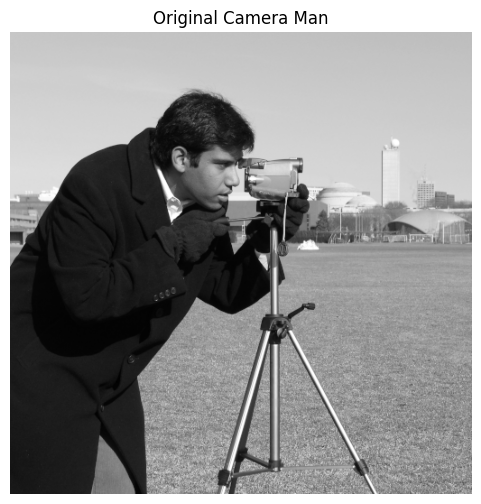

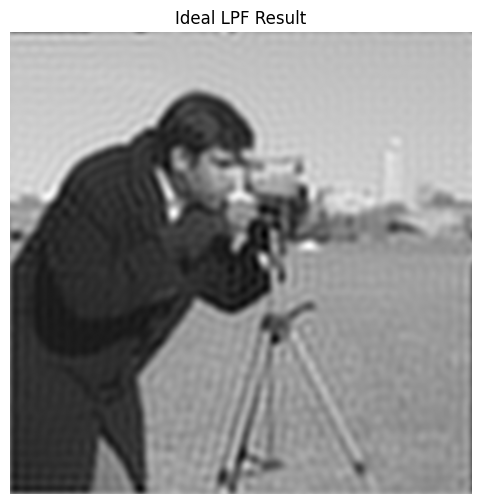

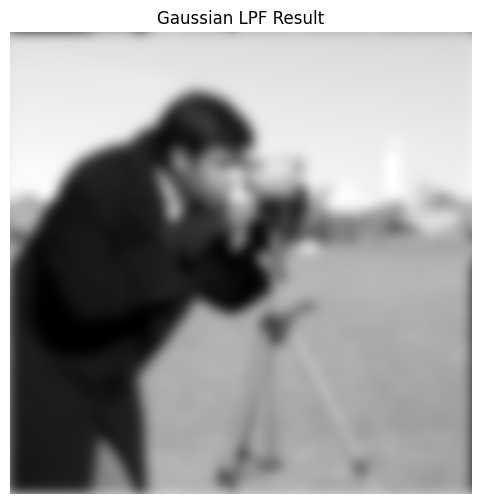

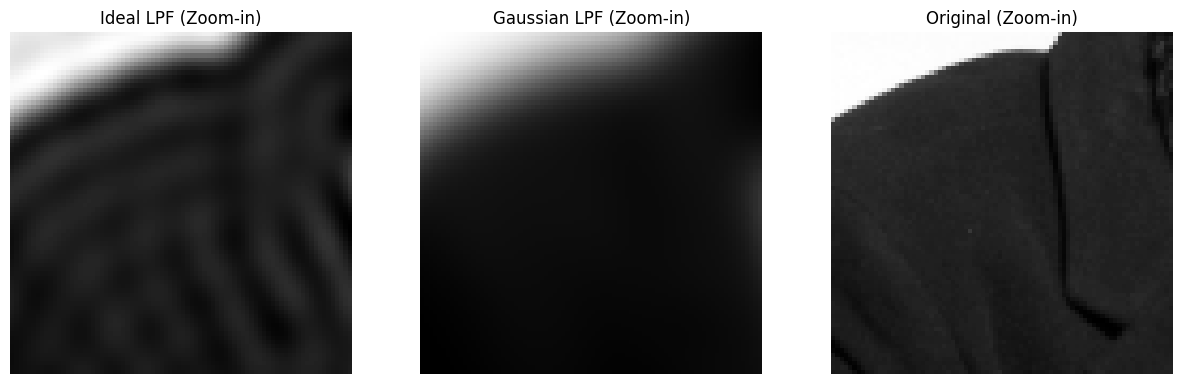

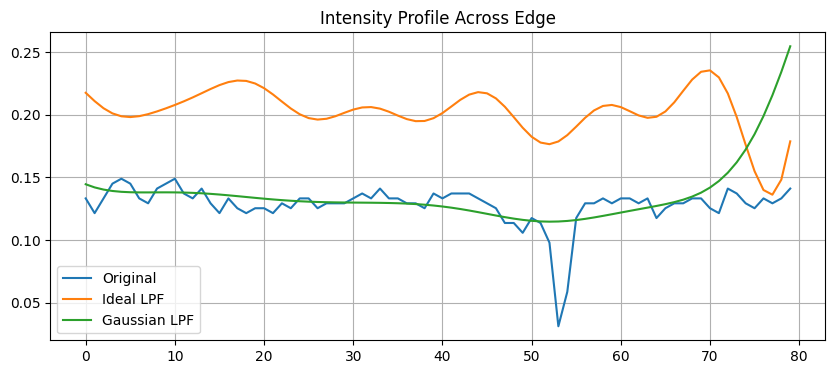

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

# Load cameraman image
img = data.camera().astype(np.float32) / 255.0

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title("Original Camera Man")
plt.axis('off')

def ideal_lpf(img, cutoff=40):
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2

    # FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    # Ideal LPF (binary mask)
    mask = np.zeros((rows, cols), np.uint8)

    for i in range(rows):
        for j in range(cols):
            if np.sqrt((i - crow)**2 + (j - ccol)**2) <= cutoff:
                mask[i,j] = 1

    filtered = fshift * mask
    ishift = np.fft.ifftshift(filtered)
    img_back = np.real(np.fft.ifft2(ishift))

    # Normalize
    img_back = (img_back - img_back.min()) / (img_back.max() - img_back.min())
    return img_back

ideal_lpf_img = ideal_lpf(img, cutoff=40)

plt.figure(figsize=(6,6))
plt.imshow(ideal_lpf_img, cmap='gray')
plt.title("Ideal LPF Result")
plt.axis('off')

def gaussian_lpf(img, sigma=8):
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2

    # FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    # Gaussian filter
    x = np.linspace(-crow, crow, rows)
    y = np.linspace(-ccol, ccol, cols)
    X, Y = np.meshgrid(x, y)
    H = np.exp(-(X**2 + Y**2) / (2 * sigma**2))

    filtered = fshift * H
    ishift = np.fft.ifftshift(filtered)
    img_back = np.real(np.fft.ifft2(ishift))

    img_back = (img_back - img_back.min()) / (img_back.max() - img_back.min())
    return img_back

gaussian_lpf_img = gaussian_lpf(img, sigma=12)

plt.figure(figsize=(6,6))
plt.imshow(gaussian_lpf_img, cmap='gray')
plt.title("Gaussian LPF Result")
plt.axis('off')

# Crop area - adjust as needed
crop = (slice(120, 200), slice(80, 160))

orig_crop     = img[crop]
ideal_crop    = ideal_lpf_img[crop]
gauss_crop    = gaussian_lpf_img[crop]

fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].imshow(ideal_crop, cmap='gray')
ax[0].set_title("Ideal LPF (Zoom-in)")
ax[0].axis('off')

ax[1].imshow(gauss_crop, cmap='gray')
ax[1].set_title("Gaussian LPF (Zoom-in)")
ax[1].axis('off')

ax[2].imshow(orig_crop, cmap='gray')
ax[2].set_title("Original (Zoom-in)")
ax[2].axis('off')

plt.show()

# Ambil 1 garis horizontal pada edge
line_index = 40  # index dalam crop

orig_line  = orig_crop[line_index, :]
ideal_line = ideal_crop[line_index, :]
gauss_line = gauss_crop[line_index, :]

plt.figure(figsize=(10,4))
plt.plot(orig_line,  label="Original")
plt.plot(ideal_line, label="Ideal LPF")
plt.plot(gauss_line, label="Gaussian LPF")
plt.title("Intensity Profile Across Edge")
plt.legend()
plt.grid(True)
plt.show()

## ***Latihan 4 : Denoising + Canny (Citra Coins)***

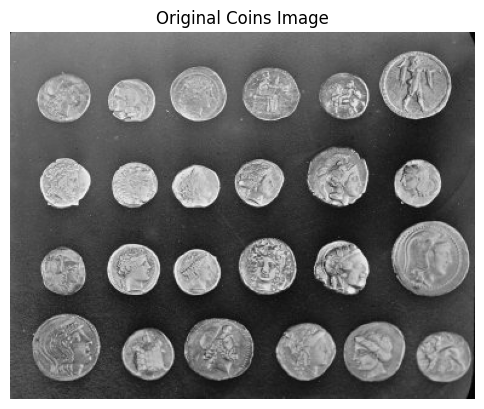

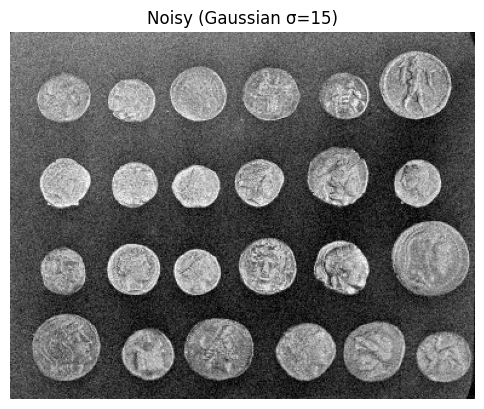

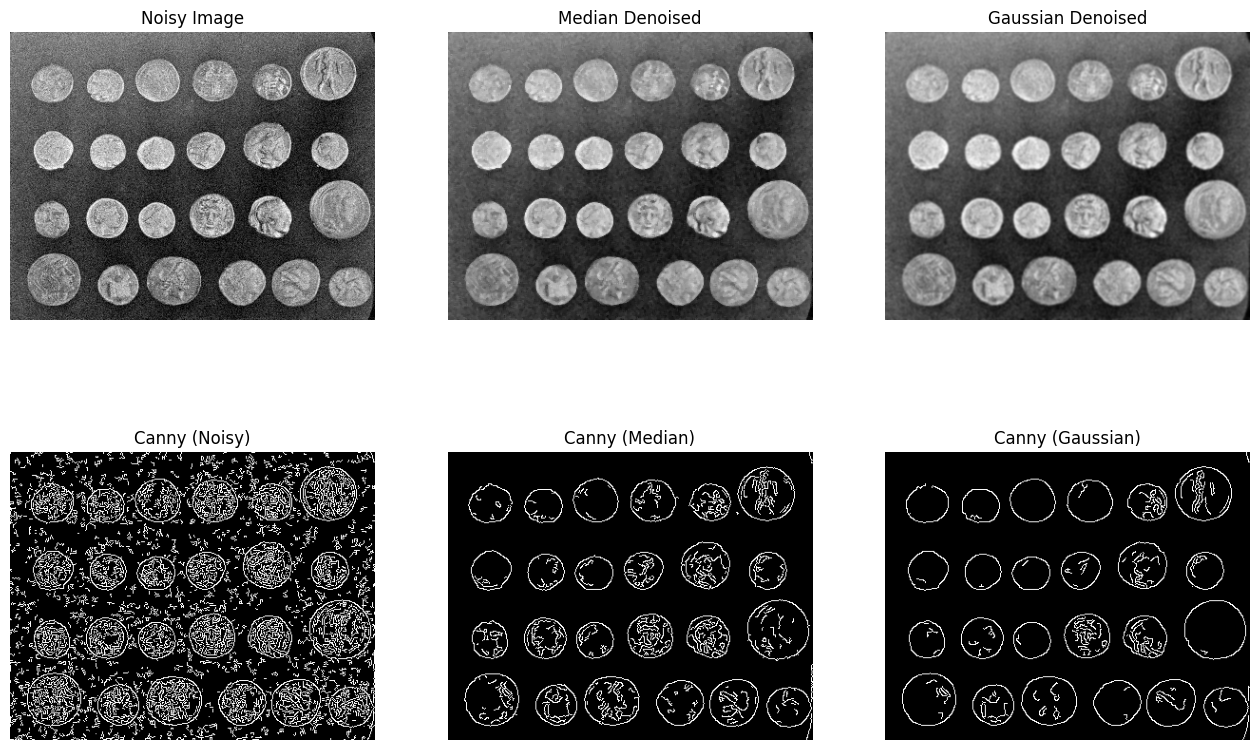

(np.float64(-0.5), np.float64(383.5), np.float64(302.5), np.float64(-0.5))

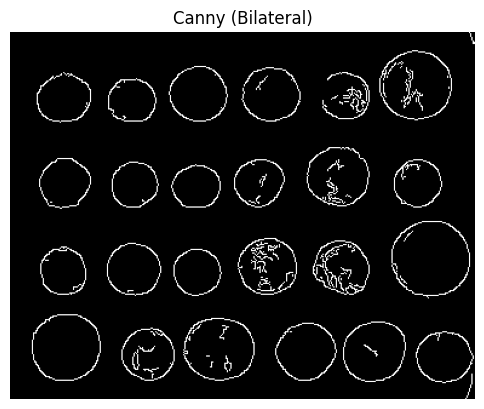

In [ ]:
# ===============================================================
# 1. Import Library
# ===============================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from scipy.ndimage import median_filter, gaussian_filter

# ===============================================================
# 2. Load Image (Coins)
# ===============================================================
img = data.coins()
img = img.astype(np.float32)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title("Original Coins Image")
plt.axis('off')

sigma = 15
noise = np.random.normal(0, sigma, img.shape)
noisy = img + noise
noisy = np.clip(noisy, 0, 255)

plt.figure(figsize=(6,6))
plt.imshow(noisy, cmap='gray')
plt.title("Noisy (Gaussian σ=15)")
plt.axis('off')

# Median filter
den_median = median_filter(noisy, size=3)

# Gaussian filter
den_gaussian = gaussian_filter(noisy, sigma=1)

# Bilateral filter
den_bilateral = cv2.bilateralFilter(noisy.astype(np.uint8),
                                    d=9, sigmaColor=50, sigmaSpace=50)

edges_noisy      = cv2.Canny(noisy.astype(np.uint8),       100, 200)
edges_median     = cv2.Canny(den_median.astype(np.uint8),  100, 200)
edges_gaussian   = cv2.Canny(den_gaussian.astype(np.uint8),100, 200)
edges_bilateral  = cv2.Canny(den_bilateral,                100, 200)

fig, ax = plt.subplots(2,3, figsize=(16,10))

ax[0,0].imshow(noisy, cmap='gray')
ax[0,0].set_title("Noisy Image")
ax[0,0].axis('off')

ax[0,1].imshow(den_median, cmap='gray')
ax[0,1].set_title("Median Denoised")
ax[0,1].axis('off')

ax[0,2].imshow(den_gaussian, cmap='gray')
ax[0,2].set_title("Gaussian Denoised")
ax[0,2].axis('off')

ax[1,0].imshow(edges_noisy, cmap='gray')
ax[1,0].set_title("Canny (Noisy)")
ax[1,0].axis('off')

ax[1,1].imshow(edges_median, cmap='gray')
ax[1,1].set_title("Canny (Median)")
ax[1,1].axis('off')

ax[1,2].imshow(edges_gaussian, cmap='gray')
ax[1,2].set_title("Canny (Gaussian)")
ax[1,2].axis('off')

plt.show()

# Bilateral ditampilkan terpisah
plt.figure(figsize=(6,6))
plt.imshow(edges_bilateral, cmap='gray')
plt.title("Canny (Bilateral)")
plt.axis('off')